In [124]:
import patsy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import column_or_1d

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(1)

In [3]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [4]:
Smarket.select_dtypes('number').corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

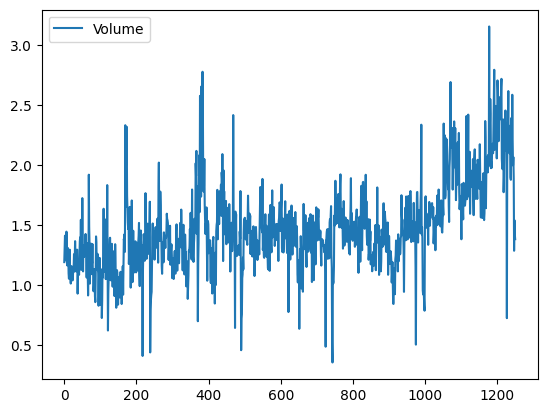

In [5]:
Smarket.plot(y='Volume')

# Logistic Regression

In [6]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [7]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [8]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [9]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [10]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = 'Up'

In [11]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [12]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [13]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [14]:
X_test

,intercept,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
998,1.0,-0.134,0.008,-0.007,0.715,-0.431,0.78690
999,1.0,-0.812,-0.134,0.008,-0.007,0.715,1.51080
1000,1.0,-1.167,-0.812,-0.134,0.008,-0.007,1.72100
1001,1.0,-0.363,-1.167,-0.812,-0.134,0.008,1.73890
1002,1.0,0.351,-0.363,-1.167,-0.812,-0.134,1.56910
...,...,...,...,...,...,...,...
1245,1.0,0.422,0.252,-0.024,-0.584,-0.285,1.88850
1246,1.0,0.043,0.422,0.252,-0.024,-0.584,1.28581
1247,1.0,-0.955,0.043,0.422,0.252,-0.024,1.54047
1248,1.0,0.130,-0.955,0.043,0.422,0.252,1.42236


In [15]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [16]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [17]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [18]:
(35+106)/252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [19]:
# How to predict using particular values

newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]})
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# Linear Discriminant Analysis

In [20]:
lda = LDA(store_covariance=True)

In [21]:
X_train

,intercept,Lag1,Lag2
0,1.0,0.381,-0.192
1,1.0,0.959,0.381
2,1.0,1.032,0.959
3,1.0,-0.623,1.032
4,1.0,0.614,-0.623
...,...,...,...
993,1.0,0.046,0.342
994,1.0,-0.431,0.046
995,1.0,0.715,-0.431
996,1.0,-0.007,0.715


In [22]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]

lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [23]:
L_train

0        Up
1        Up
2      Down
3        Up
4        Up
       ... 
993    Down
994      Up
995    Down
996      Up
997    Down
Name: Direction, Length: 998, dtype: object

In [24]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [91]:
lda.classes_

array([0, 1])

In [26]:
lda.priors_

array([0.49198397, 0.50801603])

In [27]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

These values provide the linear combination of Lag1 and Lag2 that are used
to form the LDA decision rule. In other words, these are the multipliers of
the elements of X = x in (4.24). If −0.64 × Lag1 − 0.51 × Lag2 is large,
then the LDA classifier will predict a market increase, and if it is small,
then the LDA classifier will predict a market decline.

In [28]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [29]:
lda_prob = lda.predict_proba(X_test)

In [30]:
np.all([lda.classes_[i] for i in np.argmax(lda_prob , 1)]==lda_pred)

True

In [31]:
np.sum(lda_prob[:,0] > 0.9) # to find out how many days have a higher posterior probability than 0.9

0

# Quadratic Discriminant Analysis

In [32]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [33]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [34]:
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

In [35]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [36]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [37]:
np.mean(qda_pred == L_test)

0.5992063492063492

# Naive Bayes

In [38]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [39]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [40]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [41]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [42]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [43]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [44]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# K-Nearest Neighbors

In [45]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [46]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, L_train)
knn3_pred = knn3.predict(X_test)
confusion_table(knn3_pred, L_test)

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [47]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [48]:
feature_df = Caravan.drop(columns=['Purchase'])

In [49]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

feature_std = pd.DataFrame(
    X_std,
    columns=feature_df.columns)

In [50]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(feature_std,
                            Purchase,
                            test_size=1000,
                            random_state=0)

In [51]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)

In [52]:
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

In [53]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [54]:
for K in range(1, 8):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)

    bool = (np
     .take(a=y_test,
           indices=np.where(knn_pred=='Yes')[0])
     .value_counts())

    if len(bool) == 1:
        print(f'For n_neighbors={K} an accuracy of 0')
    else:
        print(f'For n_neighbors={K} an accuracy of {bool[1]/np.sum(bool)}')

    

For n_neighbors=1 an accuracy of 0.14516129032258066
For n_neighbors=2 an accuracy of 0.16666666666666666
For n_neighbors=3 an accuracy of 0.15
For n_neighbors=4 an accuracy of 0
For n_neighbors=5 an accuracy of 0.14285714285714285
For n_neighbors=6 an accuracy of 0
For n_neighbors=7 an accuracy of 0.2


In [55]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:, 1] > 0.5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,931,67
Yes,2,0


In [56]:
logit_labels = np.where(logit_pred[:, 1] > 0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


# Linear and the Poisson Regression on the Bikeshare Data

In [57]:
Bike = load_data('Bikeshare')

In [58]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [59]:
X = MS(['mnth',
        'hr',
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)

Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-27.2068,6.715,-4.052,0.000
mnth[Aug],11.8181,4.698,2.515,0.012
mnth[Dec],5.0328,4.280,1.176,0.240
mnth[Feb],-34.5797,4.575,-7.558,0.000
mnth[Jan],-41.4249,4.972,-8.331,0.000
mnth[July],3.8996,5.003,0.779,0.436
mnth[June],26.3938,4.642,5.686,0.000
mnth[March],-24.8735,4.277,-5.815,0.000
mnth[May],31.1322,4.150,7.501,0.000
mnth[Nov],18.8851,4.099,4.607,0.000


In [60]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [61]:
X2 = MS([mnth_encode,
         hr_encode,
         'workingday',
         'temp',
         'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)

What is the difference between the two codings? In M2_lm, a coefficient esti-
mate is reported for all but level 23 of hr and level Dec of mnth. Importantly,
in M2_lm, the (unreported) coefficient estimate for the last level of mnth is
not zero: instead, it equals the negative of the sum of the coefficient esti-
mates for all of the other levels. Similarly, in M2_lm, the coefficient estimate
for the last level of hr is the negative of the sum of the coefficient estimates
for all of the other levels. This means that the coefficients of hr and mnth
in M2_lm will always sum to zero, and can be interpreted as the difference
from the mean level. For example, the coefficient for January of −46.087
indicates that, holding all other variables constant, there are typically 46
fewer riders in January relative to the yearly average.

In [62]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_hr = S2[S2.index.str.contains('hr')]['coef']

In [63]:
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                  index=['mnth[Dec]'])
                       ])
hrs = Bike['hr'].dtype.categories
coef_hr = pd.concat([coef_hr,
                        pd.Series([-coef_hr.sum()],
                                  index=['hr[23]'])
                       ])

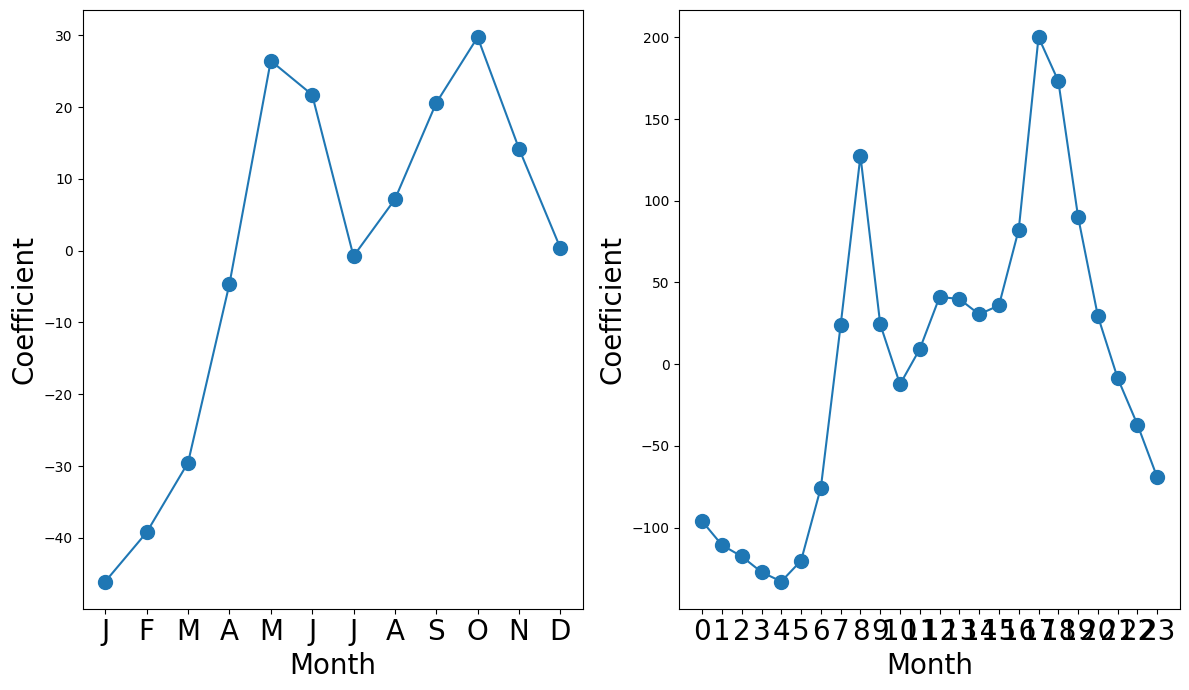

In [64]:
fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(121)
x_month = np.arange(coef_month.shape[0])
ax1.plot(x_month, coef_month, marker='o', ms=10)
ax1.set_xticks(x_month)
ax1.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax1.set_xlabel('Month', fontsize=20)
ax1.set_ylabel('Coefficient', fontsize=20)

ax2 = fig.add_subplot(122)
x_hr = np.arange(coef_hr.shape[0])
ax2.plot(x_hr, coef_hr, marker='o', ms=10)
ax2.set_xticks(x_hr)
ax2.set_xticklabels([h[3:-1] for h in coef_hr.index], fontsize=20)
ax2.set_xlabel('Month', fontsize=20)
ax2.set_ylabel('Coefficient', fontsize=20)

plt.tight_layout()
plt.show()

In [65]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                  index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()],
                               index=['hr[23'])])

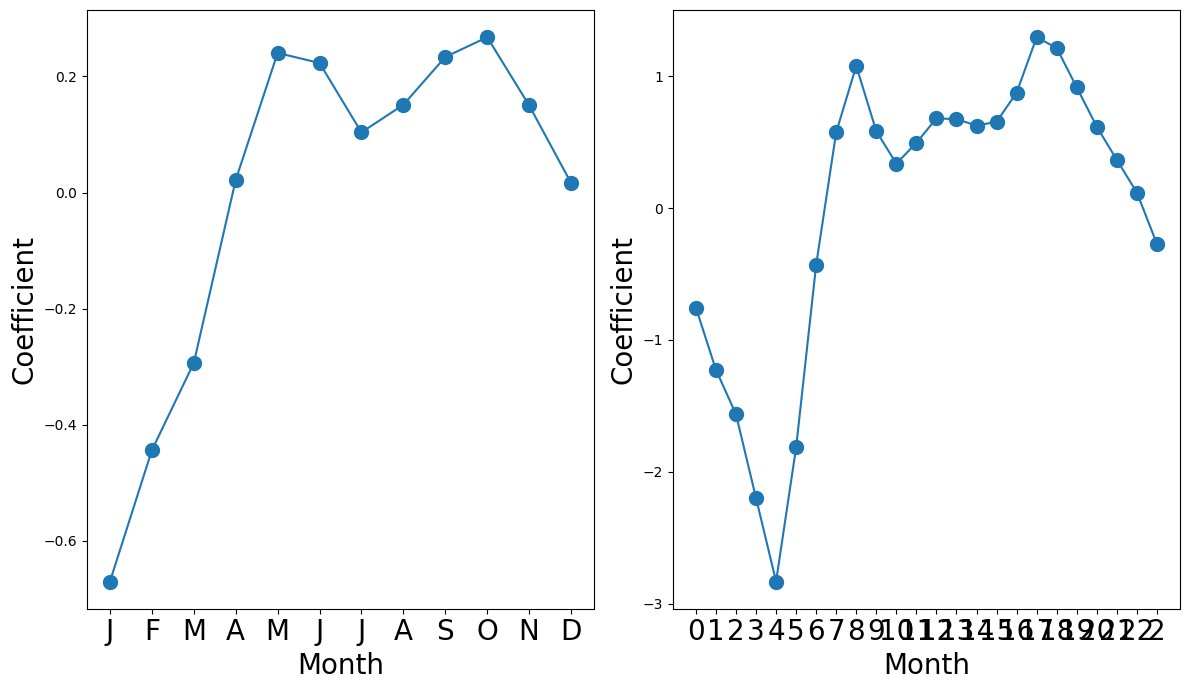

In [66]:
fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(121)
x_month = np.arange(coef_month.shape[0])
ax1.plot(x_month, coef_month, marker='o', ms=10)
ax1.set_xticks(x_month)
ax1.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax1.set_xlabel('Month', fontsize=20)
ax1.set_ylabel('Coefficient', fontsize=20)

ax2 = fig.add_subplot(122)
x_hr = np.arange(coef_hr.shape[0])
ax2.plot(x_hr, coef_hr, marker='o', ms=10)
ax2.set_xticks(x_hr)
ax2.set_xticklabels([h[3:-1] for h in coef_hr.index], fontsize=20)
ax2.set_xlabel('Month', fontsize=20)
ax2.set_ylabel('Coefficient', fontsize=20)

plt.tight_layout()
plt.show()

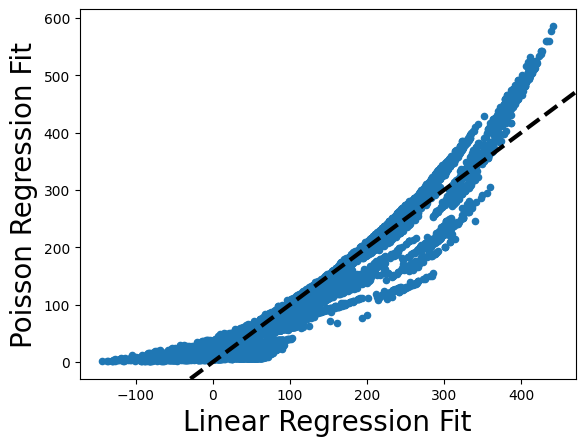

In [67]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(M2_lm.fittedvalues,
           M_pois.fittedvalues,
           s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
          linestyle='--', slope=1)

# Exercises

Conceptual
(for the algebra questions just look at https://rpubs.com/ppaquay/65560)

1. Using a little bit of algebra, prove that (4.2) is equivalent to (4.3). In other words, the logistic function representation and logit representation for the logistic regression model are equivalent.
https://i.imgur.com/fvqNBfo.png
2. It was stated in the text that classifying an observation to the class for which (4.17) is largest is equivalent to classifying an observation to the class for which (4.18) is largest. Prove that this is the case. In other words, under the assumption that the observations in the kth class are drawn from a N(μk,σ2) distribution, the Bayes classifier assigns an observation to the class for which the discriminant function is maximized.
3. This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p=1; i.e there is only one feature.
Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X∼N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.
4. When the number of features p is large, there tends to be a deterioration in the performance of KNN and other local approaches that perform prediction using only the observations that are near the test observation for which a prediction must be made. This phenomenon is known as the curse of dimensionality, and it ties into the fact that non-parametric approaches often perform poorly when p is large. We will now investigate this curse.

   (a) Suppose that we have a set of observations, each with measurements on p=1 feature, X. We assume that X is uniformly (evenly) distributed on [0,1]. Associated with each observation is a response value. Suppose that we wish to predict a test observation's response using only observations that are within 10% of the range of X closest to that test observation. For instance, in order to predict the response for a test observation with X = 0.6, we will use observations in the range [0.55, 0.65]. On average, what fraction of the available observations will we use to make the prediction?

   https://www.kaggle.com/code/suugaku/islr-chapter-4-conceptual-exercises

5. We now examine the differences between LDA and QDA.

   (a) If the Bayes decision boundary is linear, do we expect LDA or QDA to perform better on the training set? On the test set?
   QDA performs better on the training set and worse on the test set.
   or
   When the Bayes decision boundary is linear, we expect QDA to have lower training error as a result of its increased flexibility over LDA. However, we would expect LDA to have lower test error since it produces a linear decision boundary, is also the shape of the Bayes decision boundary in this case. The higher variance introduced by the flexibility of QDA wouldn't be offset by the lower bias, so QDA is an overly flexible model for this situation.

   (b) If the Bayes decision boundary is non-linear, do we expect LDA or QDA to perform better on the training set? On the test set?
   QDA performs better on both.

   (c) In general, as the sample size n increases, do we expect the test prediction accuracy of QDA relative to LDA to improve, decline or be unchanged? Why?
   QDA should in theory improve since it will better fit the data. LDA will have more accuracy if the n is small.
   or
   As the sample size n increases, the we generally expect the test prediction of QDA relative to LDA to improve. This is because as the size of the training set increases, reducing model variance becomes less crucial, since no change in a single data point is likely to greatly affect the model compared to when there are a small number of training observations.
   (d) True or False: Even if the Bayes decision boundary for a given problem is linear, we will probably achieve a superior test error rate using QDA rather than LDA because QDA is flexible enough to model a linear decision boundary. Justify your answer.
   It is true that QDA can model a linear decision boundary but LDA will still have lower test error rate because the Bayes decision boundary is linear.
   or
   False. If we have few training observations, the increased flexibility of QDA over LDA will likely lead to QDA overfitting to the random noise in the training set. This would then result in a worse test error rate when using QDA compared to the test error rate for LDA. In other words, when there are few training observations, reducing model variance is crucial, so the increased variance in QDA over LDA will not be offset by the reduction in bias, resulting in worse test performance from QDA.

6. Suppose we collect data for a group of students in a statistics class with variables X1=hours studied, X2=undergrad GPA and Y=receive an A. We fit a logistic regression and produce estimated coefficient, β̂0 = −6, β̂1 = 0.05, β̂2 = 1.

   (a) Estimate the probability that a student who studies for 40h and has an undergrad GPA of 3.5 gets an A in the class.

In [68]:
probability = np.exp(-6 + 0.05*40 + 1*3.5)
probability = probability/(1+probability)
print('The probability is equal to', probability)

The probability is equal to 0.37754066879814546


    (b) How many hours would the student in part (a) need to study to have a 50% chance of getting an A in the class?

In [69]:
intercept = -6
b1_coef = 0.05
b2_coef = 1

b1x = -intercept - b2_coef*3.5
x = b1x / 0.05
print(f'The student should study at least {x} hours to get an A')

The student should study at least 50.0 hours to get an A


7. Suppose that we wish to predict whether a given stock will issue a dividend this year based on X, last year's percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was Xmean=10, while the mean for those that didn't was Xmean=0. In addition, the variance of X for these two sets of companies was σ̂ 2=36. Finally, 80% of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X=4 last year. 

In [70]:
# done with chatgpt cuz i am too stupid

import numpy as np
import math

def pdf_k(x, mu_k, sigma):
    return (1 / (math.sqrt(2 * math.pi) * sigma)) * np.exp(-((x - mu_k) ** 2) / (2 * sigma ** 2))

sigma = 6  # both classes

# class 1, companies that issued a dividend
pi_1 = 0.8
mu_1 = 10

# class 2, companies that didn't issue a dividend
pi_2 = 0.2
mu_2 = 0

# computing probabilities
x = 4
p_1 = (pi_1 * pdf_k(4, mu_1, sigma)) / (pi_1 * pdf_k(4, mu_1, sigma) + pi_2 * pdf_k(4, mu_2, sigma))
p_2 = (pi_2 * pdf_k(4, mu_2, sigma)) / (pi_1 * pdf_k(4, mu_1, sigma) + pi_2 * pdf_k(4, mu_2, sigma))

# rounding the numbers
p_1 = round(p_1, 3)
p_2 = round(p_2, 3)

# display probabilities
print("Probability of Class 1 (Dividend):", p_1)
print("Probability of Class 2 (Non-Dividend):", p_2)


Probability of Class 1 (Dividend): 0.752
Probability of Class 2 (Non-Dividend): 0.248


8. Suppose that we take a data set, divide it into equally-sized training and test sets, and then try out two different classification procedures. First we use logistic regression and get an error rate of 20% on the training data and 30% on the test data. Next we use 1-nearest neighbors and get an average error rate (averaged over both test and training data sets) of 18%. Based on these results, which method should we prefer to use for classification of new observations? Why?

For inference purposes, since the test error rate is not that much different, we can use logistic regression.

Also for this reason:
"In the case of KNN with K=1, we have a training error rate of 0% because in this case, we have
P(Y=j|X=xi)=I(yi=j)
which is equal to 1 if yi=j and 0 if not. We do not make any error on the training data within this setting, that explains the 0% training error rate. However, we have an average error rate of 18% wich implies a test error rate of 36% for KNN which is greater than the test error rate for logistic regression of 30%. So, it is better to choose logistic regression because of its lower test error rate."

9. This problem has to do with odds.

   (a) On average, what fraction of people with an odds of 0.37 of defauting on their credit card payment will in fact default?

In [71]:
# the 4.2 formula in the book

perc = 0.37/(1+0.37)
'The answer is {perc}.'.format(perc=perc*100)

'The answer is 27.00729927007299.'

    (b) Suppose that an individual has a 16% chance of defaulting on her credit card payment. What are the odds that she will default?

In [72]:
px = 0.16
odds = 0.16/(1-0.16)
print('The odds are', odds)

The odds are 0.1904761904761905


10. Equation 4.32 derived an expression for log etc. in the setting where p>1, so that the mean for the kth class, μk, is a p-dimensional vector, and the shared covariance Σ is a p × p matrix. However, in the setting with p=1, (4.32) takes a simpler form, since the means μ1 , . . . , μK and the variance σ^2 are scalars. In this simpler setting, repeat the calculation in 4.32 and provide expressions for ak and bkj in terms of πk , πK , μk , μK , and σ^2.

11. Work out the detailed forms of ak , bkj , and bkjl in (4.33). Your answer
should involve πk , πK , μk , μK , Σk , and ΣK .

12. Suppose that you wish to classify an observation X ∈ R into apples
and oranges. You fit a logistic regression model and find that [insert formula] . Your friend fits a logistic regression model to the same data using the softmax formulation in 4.13, and finds that [insert formula].

Help:https://rpubs.com/hardym/961056
    
    (a) What is the log odds of orange versus apple in your model?
    (b) What is the log odds of orange versus apple in your friend's model?
    (c) Suppose that in your model, B0^ = 2 and B1^ = -1. What are the coefficient estimates in your friend's model? Be as specific as possible.
    (d) Now suppose that you and your friend fit the same two models on a different data set. THis time, your friend gets the coefficient estimates ̂orange0 = 1.2, α̂orange1 = −2, α̂orange0 = 3, α̂orange1 = 0.6. What are the coefficient estimates in your model?
    (e) Finalluy, suppose you apply both models from (d) to a data set with 2,000 test observations. What fraction of the time do you expect the predicted calss labels from your model to agree with those from your friend's model? Explain your answer.

13. This question should be answer using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter's lab, except that it contains 1,089 weekly returns for 21 years, from the beggining of 1990 to the end of 2010.

    (a) Produce some numerical and graphical summaries of Weekly data. Do there appear to be any patterns?

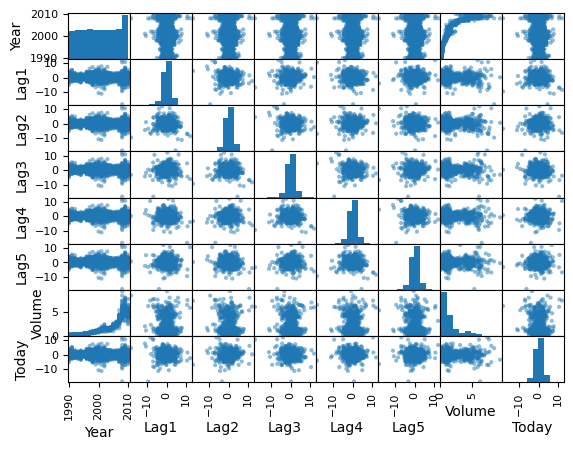

In [73]:
Weekly = load_data('Weekly')
plot = pd.plotting.scatter_matrix(Weekly)

In [74]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [75]:
# Coding up as 1 and down as 0
Weekly['Direction'] = np.where(Weekly['Direction'] == 'Up', 1, 0)

There appears to be an increase in Volume with time.

    (b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus VOlume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [76]:
X = Weekly.loc[:, 'Lag1':'Volume']
X_columns = '+'.join(X
             .columns
             .tolist())
y = Weekly['Direction']
y_columns = 'Direction'
model = (smf
         .glm(f'{y_columns} ~ {X_columns}',
              data=Weekly,
              family=sm.families.Binomial())
         .fit())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Fri, 01 Sep 2023   Deviance:                       1486.4
Time:                        08:53:17   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

Lag 2 appears to be statistically significant with a p-value of 0.03.

    (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [77]:
L_pred = np.where(model.predict(X) < 0.5, 0, 1)
cmatrix = confusion_table(L_pred, y)
print(cmatrix)
print(
    'Correct predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth        0    1
Predicted          
0           54   48
1          430  557
Correct predictions: 0.5610651974288338


The confusion matrix shows a lot of false positives and a lot of true positives.

(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 to 2010).

In [78]:
X = Weekly.loc[(Weekly['Year'] <= 2008), ('Lag2', 'Direction')]
Y = Weekly.loc[(Weekly['Year'] > 2008), ('Lag2', 'Direction')]
X_train, Y_train = (X[col] for col in X)
X_test, Y_test = (Y[col] for col in Y)

X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)

In [79]:
model = sm.GLM(Y_train,
               X_train,
               family=sm.families.Binomial()).fit()
model.summary()

Y_pred = np.where(model.predict(X_test) > 0.5,
                  1,
                  0)

cmatrix = confusion_table(Y_pred, Y_test)

print(cmatrix, \
    '\nCorrect predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth       0   1
Predicted        
0           9   5
1          34  56 
Correct predictions: 0.625


(e) Repeat (d) using LDA.

In [80]:
X_train = np.array(X_train['Lag2']).reshape(-1, 1)
X_test = np.array(X_test['Lag2']).reshape(-1, 1)

In [81]:
lda = LDA(store_covariance=True)
lda.fit(X_train, Y_train)

Y_pred = np.where(lda.predict(X_test) > 0.5,
                  1,
                  0)

cmatrix = confusion_table(Y_pred, Y_test)

print(cmatrix, \
    '\nCorrect predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth       0   1
Predicted        
0           9   5
1          34  56 
Correct predictions: 0.625


(f) Repeat (d) using QDA.

In [82]:
qda = QDA(store_covariance=True)
qda.fit(X_train, Y_train)

Y_pred = np.where(qda.predict(X_test) > 0.5,
                  1,
                  0)

cmatrix = confusion_table(Y_pred, Y_test)

print(cmatrix, \
    '\nCorrect predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth       0   1
Predicted        
0           0   0
1          43  61 
Correct predictions: 0.5865384615384616


(g) Repeat (d) using KNN with K = 1

In [83]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train, Y_train)

Y_pred = np.where(KNN.predict(X_test) > 0.5,
                  1,
                  0)

cmatrix = confusion_table(Y_pred, Y_test)

print(cmatrix, \
    '\nCorrect predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth       0   1
Predicted        
0          22  32
1          21  29 
Correct predictions: 0.49038461538461536


(h) Repeat (d) using Naive Bayes.

In [84]:
NB = GaussianNB()
NB.fit(X_train, Y_train)

Y_pred = np.where(NB.predict(X_test) > 0.5,
                  1,
                  0)

cmatrix = confusion_table(Y_pred, Y_test)

print(cmatrix, \
    '\nCorrect predictions:', \
    (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
    (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
     cmatrix.iloc[0,0] + cmatrix.iloc[1,1]))

Truth       0   1
Predicted        
0           0   0
1          43  61 
Correct predictions: 0.5865384615384616


(i) Which of these methods appears to provide the best results on this data?

The Logistic Regression and the Linear Discriminant Analysis appear to provide the best results.

(J) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [85]:
Train = Weekly.loc[(Weekly['Year'] <= 2008)]
Test = Weekly.loc[(Weekly['Year'] > 2008)]

methods = {'Logistic Regression': LogisticRegression(),
           'Linear Discriminant Analysis': LDA(),
           'Quadratic Discriminant Analysis': QDA(),
           'K Nearest Neighbors = 1': KNeighborsClassifier(1),
           'K Nearest Neighbors = 3': KNeighborsClassifier(3),
           'K Nearest Neighbors = 5': KNeighborsClassifier(5),
           'naive Bayes': GaussianNB()}

transformations = [None,
                   'np.log',
                   'np.square']

predictors = [['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'],
              ['Lag1', 'Lag2', 'Lag3', 'Lag4'],
              ['Lag1', 'Lag2'],
              ['Lag2', 'Lag5']]

interactions = [False, True]

results = pd.DataFrame(columns=['Correct_predictions',
                                'formula',
                                'method'])

def perform_classification(method, function, formula,
                           X_train, Y_train, X_test, Y_test):
    function.fit(X_train, Y_train)
    
    Y_pred = np.where(function.predict(X_test) > 0.5,
                      1,
                      0)

    cmatrix = confusion_table(Y_pred, Y_test)
    correct_predictions = (cmatrix.iloc[0,0] + cmatrix.iloc[1,1]) / \
                          (cmatrix.iloc[0,1] + cmatrix.iloc[1,0] + \
                           cmatrix.iloc[0,0] + cmatrix.iloc[1,1])
    
    # print('For', method, 'with formula', formula, '\n', \
    #     cmatrix, \
    #     '\nCorrect predictions:', correct_predictions, '\n')
    results.loc[len(results.index)] = [correct_predictions, formula, function] 
    
formulas = []
for predictor in predictors:
    for interaction in interactions:
        for transformation in transformations:
            formula = ''
            if transformation:
                for feature in predictor:
                    formula += f'{transformation}({feature}) '
            else:
                formula += ' '.join(predictor) + ' '
            if interaction and len(predictor) > 1:
                formula += '*'.join(predictor)
            formula = formula.strip()
            formula = '+'.join(formula.split(' '))
            formulas.append(formula)
formulas = list(dict.fromkeys(formulas))

for formula in formulas:
    for method, function in methods.items():
        (Y_train, X_train), (Y_test, X_test) = (patsy.dmatrices(f'Direction ~ 1 + {formula}', data) for data in (Train, Test))
        Y_train = np.ravel(Y_train)
        Y_test = np.ravel(Y_test)
        perform_classification(method, function, formula, X_train, Y_train, X_test, Y_test)

In [93]:
better_results = results.sort_values(by='Correct_predictions', ascending=False).iloc[:2]

for index, row in better_results.iterrows():
    print(f'Formula: {row["formula"]}; method: {row["method"]}; error rate: {np.round(1-row["Correct_predictions"],2)}')

Formula: np.log(Lag1)+np.log(Lag2)+np.log(Lag3)+np.log(Lag4)+Lag1*Lag2*Lag3*Lag4; method: GaussianNB(); error rate: 0.33
Formula: np.square(Lag2)+np.square(Lag5); method: KNeighborsClassifier(n_neighbors=3); error rate: 0.37


14. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [100]:
Auto = load_data('Auto')

    (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() method of the data frame. Note you may find it helpful to add a column mpg01 to the data frame by assignment. Assuming you have stored the data frame as Auto, this can be done as follows:
    
    Auto['mpg01'] = mpg01

In [101]:
mpg_median = Auto['mpg'].median()
mpg = Auto['mpg']
mpg01 = np.where(mpg > mpg_median, 1, 0)
Auto['mpg01'] = mpg01

    (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your finding.

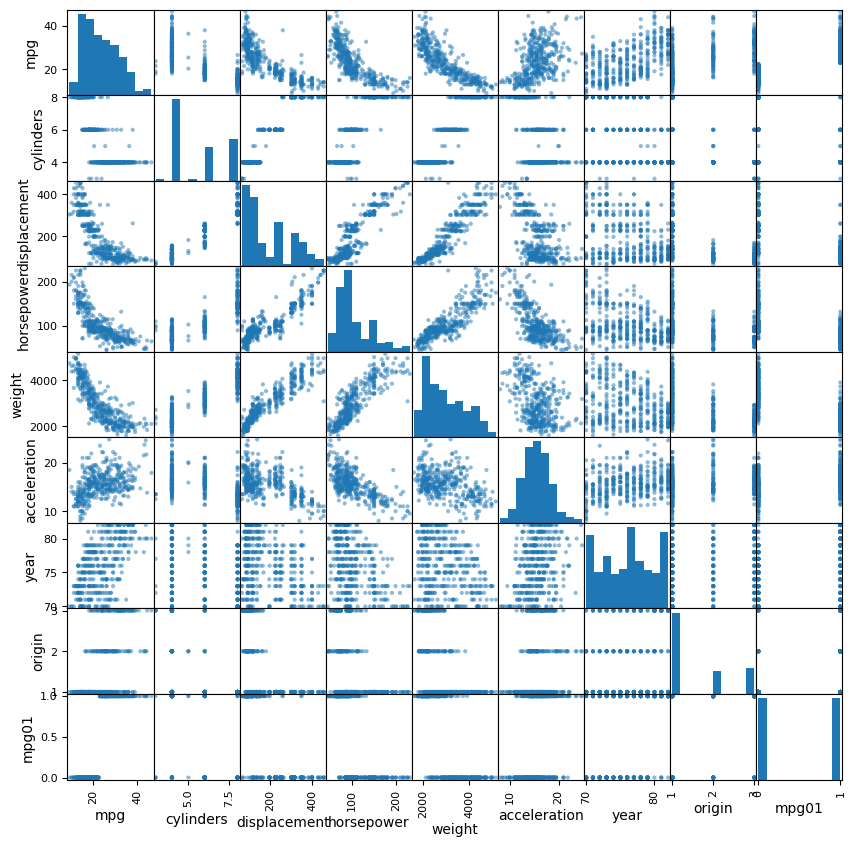

In [109]:
plot = pd.plotting.scatter_matrix(Auto, figsize=(10,10))

Now lets write some Python code for the boxplots...

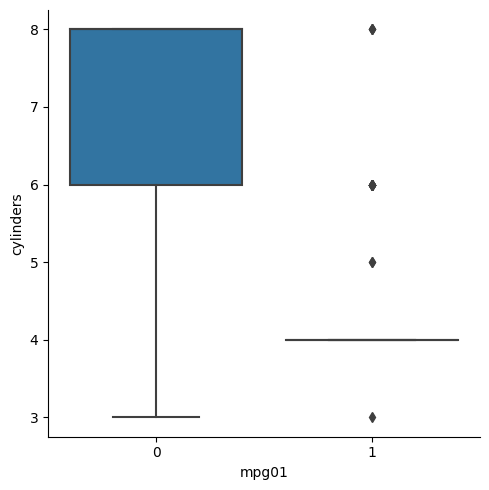

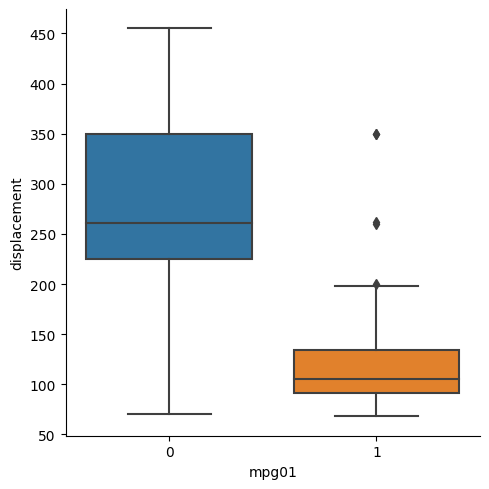

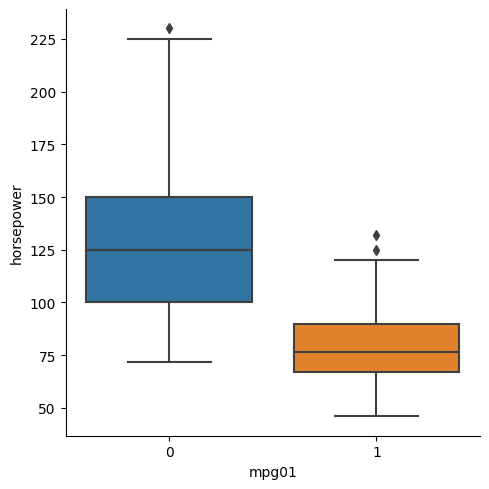

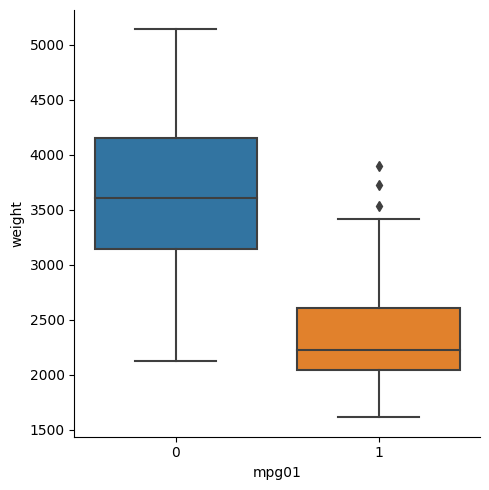

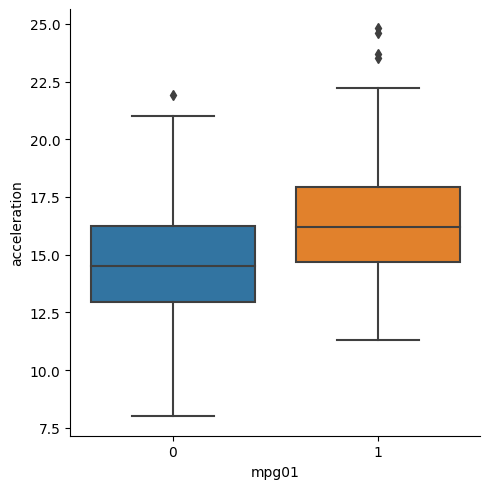

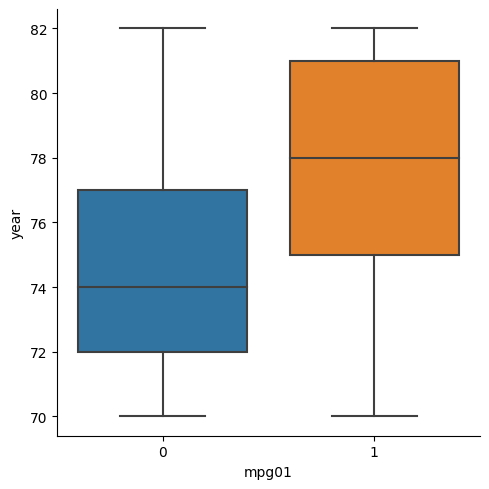

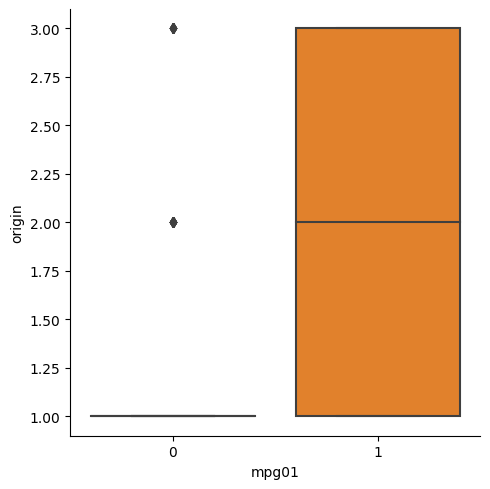

In [138]:
numerical_predictors = Auto.select_dtypes('number').columns[1:-1]

for i, predictor in enumerate(numerical_predictors):
    sns.catplot(data=Auto,
                y=predictor,
                x='mpg01',
                kind='box',
                ax=axs[i])

plt.show()

displacement, horsepower, weight, acceleration, year are all great variables to predict mpg01 according to these boxplots.

    (c) Split the data into a training set and a test set.

In [262]:
X = Auto.loc[:, ('displacement', 'horsepower', 'weight', 'acceleration')]
y = Auto['mpg01']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=1)

    (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [263]:
lda = LDA(store_covariance=True)
lda.fit(X=X_train, y=Y_train)
Y_pred = lda.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.0759493670886076

    (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [264]:
qda = QDA(store_covariance=True)
qda.fit(X=X_train, y=Y_train)
Y_pred = qda.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.0379746835443038

    (f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [265]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X=X_train, y=Y_train)
Y_pred = logisticRegression.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.0759493670886076

    (g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [266]:
naiveBayes = GaussianNB()
naiveBayes.fit(X=X_train, y=Y_train)
Y_pred = naiveBayes.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.0759493670886076

(h) Perform KNN on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [267]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=1)

for n in [1, 3, 5, 7, 9]:
    KNN = KNeighborsClassifier(n)
    KNN.fit(X=X_train, y=Y_train)
    Y_pred = KNN.predict(X_test)
    
    error_rate = np.where(Y_pred != Y_test, True, False)
    error_rate = error_rate.mean()
    print(error_rate)

0.06329113924050633
0.05063291139240506
0.0379746835443038
0.0379746835443038
0.0379746835443038


15. This problem involves writing functions.

    (a) Write a function, Power(), that prints out the result of raising 2 to the 3rd power. In other words, your function should compute 2^3 and print out the results.

In [211]:
def Power():
    print(2**3)

    (b) Create a new function, Power2(), that allows you to pass any two numbers, x and a, and prints out the value of x**a. You can do this by beggining your function with the line etc.

In [212]:
def Power2(x, a):
    print(x**a)

    (c) Using the Power2() function that you just wrote, compute 10^3, 8^17, 131^3.

In [215]:
x = Power2(10, 3), Power2(8, 17), Power2(131, 3)

1000
2251799813685248
2248091


    (d) Now create a new function, Power3(), that actually returns the result x**a as a Python object, rather than simply printing it to the screen. That is, if you can store the value x**a in an object called result within your function, then you can simply return this result.

In [216]:
def Power3(x, a):
    return x**a

    (e) Now using the Power3() function, create a plot of f(x) = x^2. The x-axis should display a range of integers from 1 to 10, and a y-axis should display x^2. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis or both on the log-scale. You can do this by using the ax.set_xscale() and ax.set_yscale() methods of the axes you are plotting to.

Text(0, 0.5, 'y')

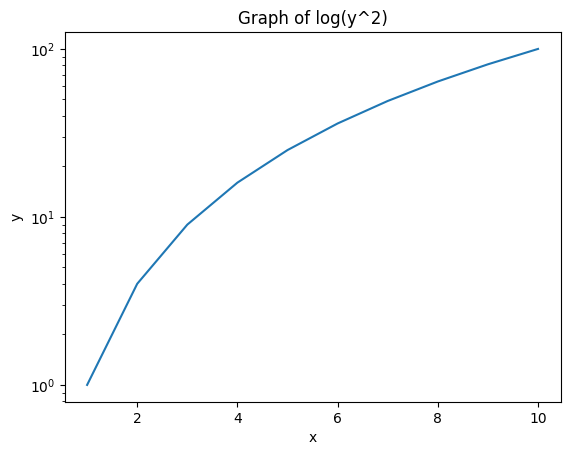

In [233]:
x = list(range(1, 11))
y = [Power3(n, 2) for n in x]

fig = plt.figure()
ax = fig.add_subplot(title='Graph of log(y^2)')
ax.plot(x, y)
ax.set_yscale('log')

ax.set_xlabel('x')
ax.set_ylabel('y')


    (f) Create a function, PlotPower(), that allows you to create a plot of x against x**a for a fixed a and a sequence of values of x.

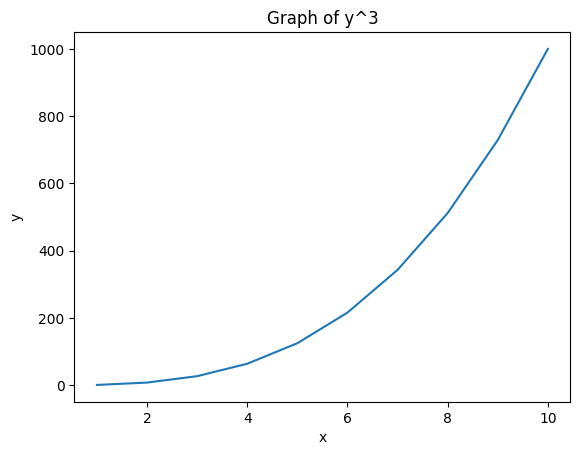

In [236]:
def PlotPower(x, a):
    y = [Power3(n, a) for n in x]
    
    fig = plt.figure()
    ax = fig.add_subplot(title=f'Graph of y^{a}')
    ax.plot(x, y)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
PlotPower(np.arange(1, 11), 3)

16. Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore the logistic regression, LDA, naive Bayes, and KNN models using various subsets of the predictors. Describe your findings.

In [238]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


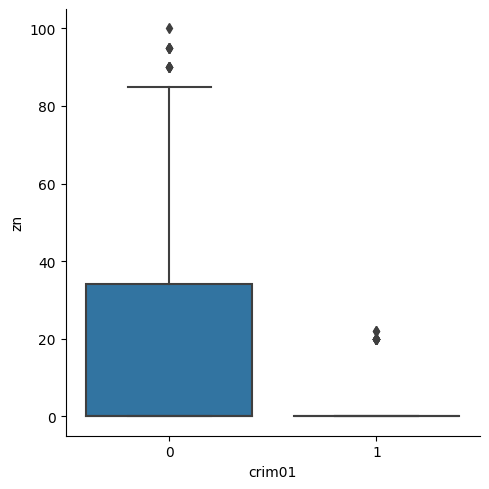

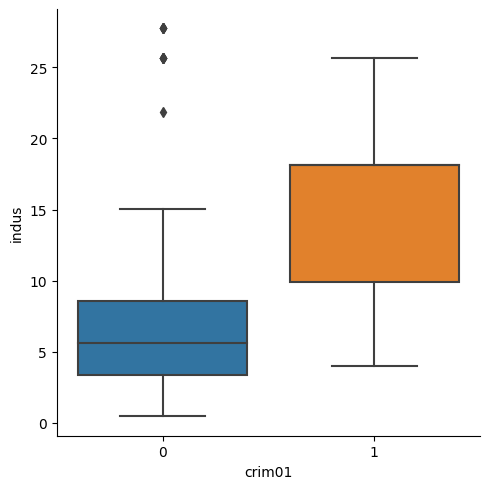

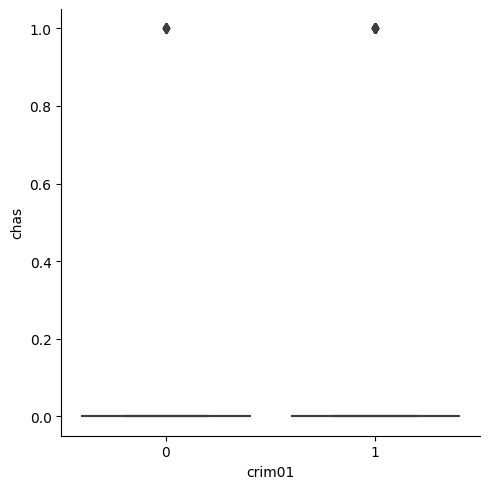

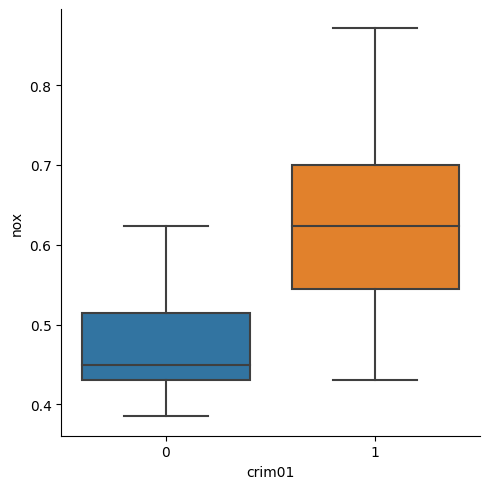

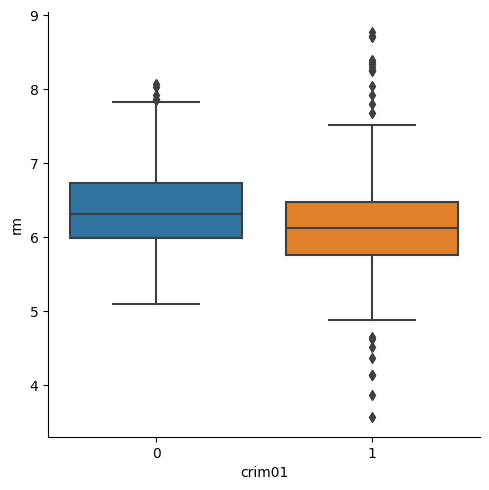

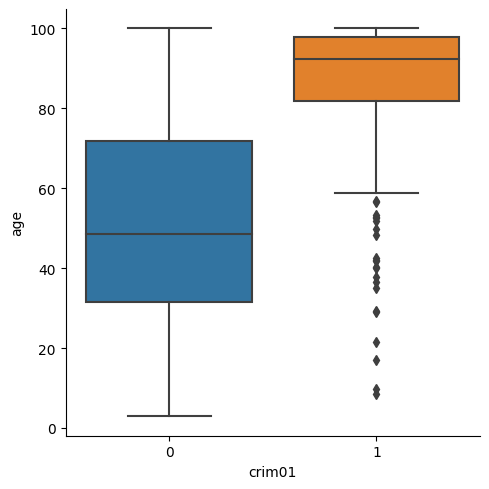

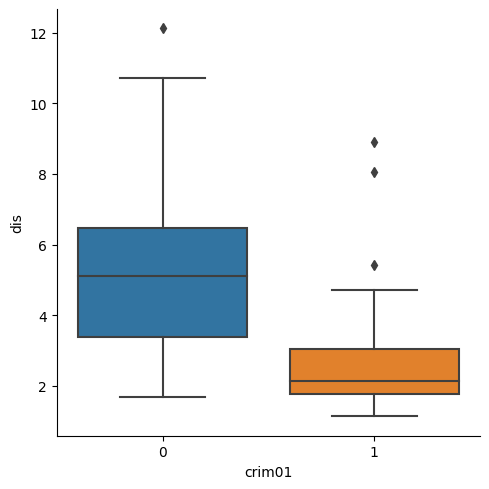

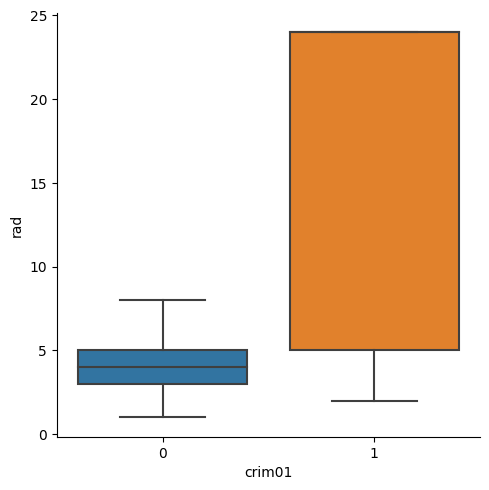

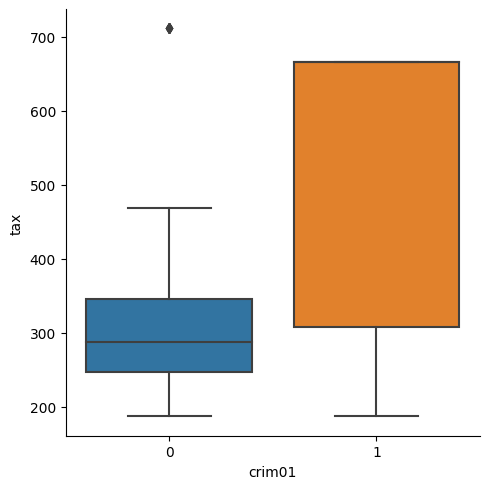

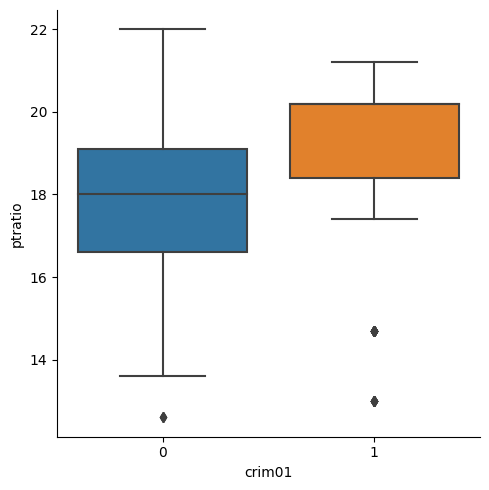

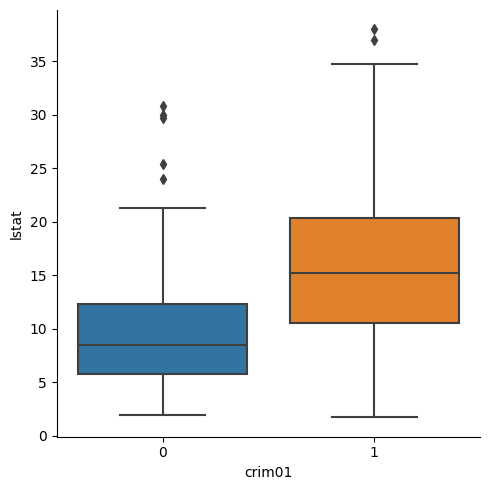

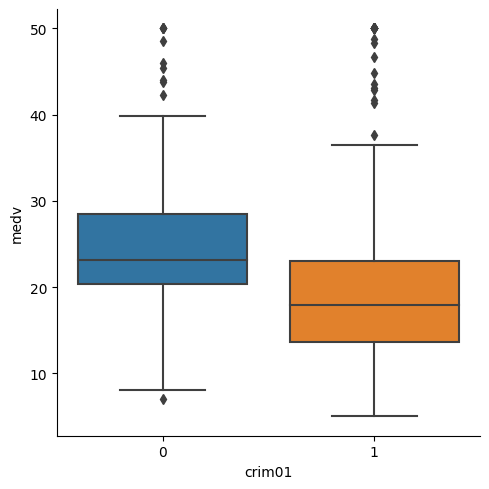

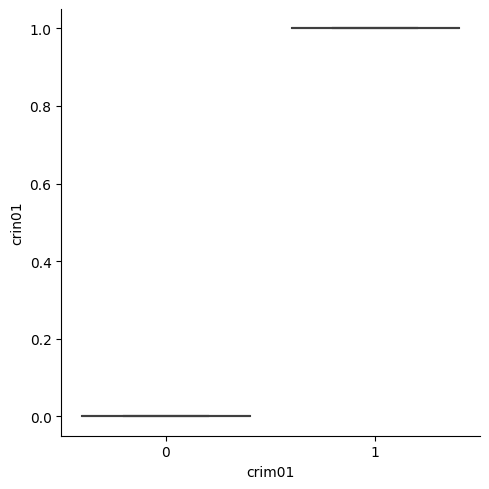

In [245]:
numerical_predictors = Boston.select_dtypes('number').columns[1:]

crim_median = Boston['crim'].median()
crim = Boston['crim']
crim01 = np.where(crim > crim_median, 1, 0)
Boston['crim01'] = crim01

for i, predictor in enumerate(numerical_predictors):
    sns.catplot(data=Boston,
                y=predictor,
                x='crim01',
                kind='box')

plt.show()

We will choose indus, nox, rm, age, dis, rad, tax, ptratio, lstat, medv as predictors.

In [252]:
X = Boston[['indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']]
y = Boston['crim01']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [253]:
lda = LDA(store_covariance=True)
lda.fit(X=X_train, y=Y_train)
Y_pred = lda.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.14705882352941177

In [254]:
qda = QDA(store_covariance=True)
qda.fit(X=X_train, y=Y_train)
Y_pred = qda.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.09803921568627451

In [255]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X=X_train, y=Y_train)
Y_pred = logisticRegression.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.1568627450980392

In [256]:
naiveBayes = GaussianNB()
naiveBayes.fit(X=X_train, y=Y_train)
Y_pred = naiveBayes.predict(X_test)

error_rate = np.where(Y_pred != Y_test, True, False)
error_rate = error_rate.mean()
error_rate

0.16666666666666666

In [260]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=1)

for n in [1, 3, 5, 7, 9, 11, 13]:
    KNN = KNeighborsClassifier(n)
    KNN.fit(X=X_train, y=Y_train)
    Y_pred = KNN.predict(X_test)
    
    error_rate = np.where(Y_pred != Y_test, True, False)
    error_rate = error_rate.mean()
    print(error_rate)

0.058823529411764705
0.09803921568627451
0.10784313725490197
0.12745098039215685
0.14705882352941177
0.13725490196078433
0.13725490196078433


Seems like knn with k=1 performs best and also QDA has a decent error rate.